# Image classification with convolutional neural networks

In this script we create, train, and evaluate an image classifier based on convolutional neural networks (CNNs).

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import copy

# Define the data repository
data_dir = 'data/'

In [2]:
# Initialization function
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    return

## Dataset

In this lab we work with the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset: it's similar to MNIST, but these are images of clothes from Zalando instead of digits.

<center><a href="https://medium.com/ml2vec/intro-to-pytorch-with-image-classification-on-a-fashion-clothes-dataset-e589682df0c5">
    <img src="https://miro.medium.com/max/1400/1*jXssb_WjoYZgepOCfdQfJA.png" width="400"></a></center>

Like MNIST, each image comes with a label between 0 and 9 (10 classes). The mapping between integer labels and actual classes (0 = t-shirt, 1 = trousers, etc.) can be found [here](https://github.com/zalandoresearch/fashion-mnist#labels).

In [3]:
# Just like MNIST, you can download the data by setting'download=True' directly from pytorch
train_data = datasets.FashionMNIST(data_dir, train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(data_dir, train=False, download=True, transform=transforms.ToTensor())
num_classes = len(train_data.classes)

# Take a subset of the train/test data
train_data = Subset(train_data, torch.arange(400))
test_data = Subset(test_data, torch.arange(50))

# Create dataloaders
batch_size = 8
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

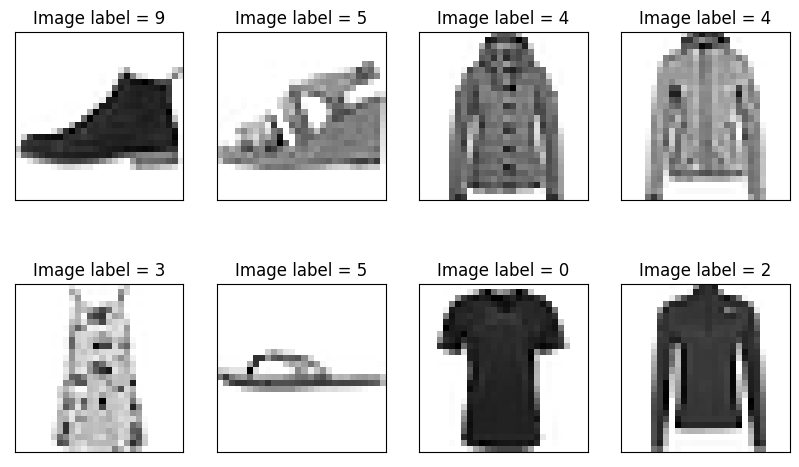

In [4]:
# Get a batch of images from the train dataloader and print it
image_batch_example, labels_batch_example = next(iter(train_dataloader))

plt.figure(figsize = (10,6))
for ib in range(batch_size):
    plt.subplot(batch_size // 4, 4, ib+1)
    plt.imshow(image_batch_example[ib, :].squeeze().detach(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Image label = ' + str(labels_batch_example[ib].item()))
plt.show()

## CNN classifier

A CNN classifier usually consists of:
- one or several convolutional layers/modules that produce intermediate latent representations called ***feature maps***
- an output linear layer performing classification from the feature maps

<center><a href="https://towardsdatascience.com/simple-introduction-to-convolutional-neural-networks-cdf8d3077bac">
    <img src="https://miro.medium.com/max/700/1*LTRcAyl6zuuJvpU-5KECZA.png"></a></center>

### Example

In [5]:
# Let us create a first CNN layer, with:
# - a convolution function, with 16 output channels, kernel_size=5, padding=2, and bias
# - a non-linear activation function (ReLU)
# - a max pooling function

cnn_layer1 = nn.Sequential(nn.Conv2d(1, 16, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.MaxPool2d(kernel_size=2))
out1 = cnn_layer1(image_batch_example)
print(out1.shape)

torch.Size([8, 16, 14, 14])


In [6]:
# TO DO: create the second CNN layer, with the same structure as the first one
# (same non-linear activation and max pooling functions), but the convolution function
# now has 16 input channels and 32 output channels
# After creating it, apply it to 'out1' to compute out2, and print the shape of out2.

cnn_layer2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.MaxPool2d(kernel_size =2))
out2 = cnn_layer2(out1)
print(out2.shape)

torch.Size([8, 32, 7, 7])


In [7]:
# Now, we define a linear layer to perform classification (as in Lab 3)

# First, we need to flatten out2, since linear layers in pytorch process vectors (or more precisely batches of vectors)
# The resulting vector should have a shape = (batch_size, 32 x 7 x 7)
out_vec = out2.reshape(out2.shape[0], -1)
print(out_vec.shape)

# TO DO: define a Linear layer with appropriate parameters
# - the input size is given by checking the shape of 'out_vec'
# - the output size is the number of classes in the dataset
# Once defined, apply this layer to out_vec

input_size_linear = out_vec.shape[1]
lin_layer = nn.Linear(input_size_linear, num_classes)
est_labels = lin_layer(out_vec)
print(est_labels.shape)

torch.Size([8, 1568])
torch.Size([8, 10])


### General module

Now, let's create a general CNN classification network, train and test it. The CNN module takes as inputs the number of output channels in each layer (and the number of classes), but we also have to explicitly provide the input size of the Linear layer, since it depends on many other parameters (image size, but also kernel, padding, stride, number of channels in the convolutions...). Instead of computing it with a general (and heavy) formula, it's easier to just get it from an example (as above), and then pass it as an input parameter.

**Note**: there are ways to alleviate this issue (e.g., using another convolution layer with as many kernels as output classes, and then global pooling)... but that's outside the scope of these labs.

In [8]:
# TO DO: Define the CNN classifier module ('__init__' and 'forward' methods).
# It's architecture is the same as in the example above.

class CNNClassif(nn.Module):
    def __init__(self, input_size_linear, num_channels1=16, num_channels2=32, num_classes=10):
        super().__init__()
        
        self.cnn_layer1 = nn.Sequential(
            nn.Conv2d(1, num_channels1, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
            
        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        
        self.lin_layer = nn.Linear(input_size_linear, num_classes)
        
    def forward(self, x):

        out = self.cnn_layer1(x)
        out = self.cnn_layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.lin_layer(out)
        return out 

In [9]:
# Instantiate the model
num_channels1 = 16
num_channels2 = 32
num_classes = 10
model = CNNClassif(input_size_linear, num_channels1, num_channels2, num_classes)

# Print the total number of parameters in the model
print('Total number of parameters: ', sum(p.numel() for p in model.parameters()))

# initialization (ensure reproducibility: everybody should have the same results)
torch.manual_seed(0)
model.apply(init_weights)

Total number of parameters:  28938


CNNClassif(
  (cnn_layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lin_layer): Linear(in_features=1568, out_features=10, bias=True)
)

## Training and evaluation

The training function is almost the same as in lab3, except we don't need to vectorize the images. Indeed, MLPs process (batches of) vectors, while CNNs directly process (batches of) images.

In [10]:
# TO DO: write the training function (no validation).

def training_cnn_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):

    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)
    
    # Set the model in 'training' mode (ensures all parameters' gradients are computed)
    model_tr.train()
    
    # define the optimizer (SGD)
    optimizer = torch.optim.SGD(model_tr.parameters(), lr=learning_rate)
    
    # Initialize a list for storing the training loss over epochs
    train_losses = []
    
    # Training loop
    for epoch in range(num_epochs):
        tr_loss = 0
        
        for batch_index, (images, labels) in enumerate(train_dataloader):

            # forward pass
            y_predicted = model_tr(images)
            loss = loss_fn(y_predicted, labels)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update the current epoch loss
            tr_loss += loss.item() * images.shape[0]

        # At the end of each epoch, get the average training loss and store it
        tr_loss = tr_loss/len(train_dataloader.dataset)
        train_losses.append(tr_loss)
        
        # Display the training loss
        if verbose:
            print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, tr_loss))
        
    return model_tr, train_losses

Epoch [1/20], Loss: 2.2194
Epoch [2/20], Loss: 1.8321
Epoch [3/20], Loss: 1.4346
Epoch [4/20], Loss: 1.2466
Epoch [5/20], Loss: 1.1169
Epoch [6/20], Loss: 1.0042
Epoch [7/20], Loss: 0.9339
Epoch [8/20], Loss: 0.8945
Epoch [9/20], Loss: 0.8292
Epoch [10/20], Loss: 0.7793
Epoch [11/20], Loss: 0.7399
Epoch [12/20], Loss: 0.7050
Epoch [13/20], Loss: 0.6700
Epoch [14/20], Loss: 0.6316
Epoch [15/20], Loss: 0.6488
Epoch [16/20], Loss: 0.6240
Epoch [17/20], Loss: 0.5812
Epoch [18/20], Loss: 0.5712
Epoch [19/20], Loss: 0.5839
Epoch [20/20], Loss: 0.5334


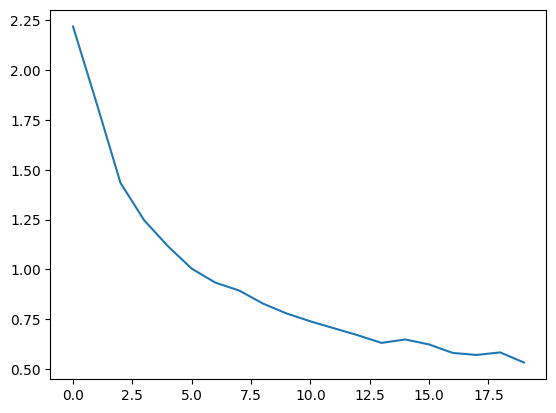

In [11]:
# Optimizer
num_epochs = 20
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.01

# Training
model, train_losses = training_cnn_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=True)

# Save the model and display the loss over epochs
torch.save(model.state_dict(), 'model_cnn_classif.pt')
plt.plot(train_losses)
plt.show()

In [12]:
# Eval function
def eval_cnn_classifier(model, eval_dataloader):

    # Set the model in evaluation mode
    model.eval() 

    # In test phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct = 0
        total = 0
        for images, labels in eval_dataloader:
            y_predicted = model(images)
            _, label_predicted = torch.max(y_predicted.data, 1)
            total += labels.size(0)
            correct += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    
    return accuracy

In [13]:
# TO DO: Evaluate the model on the test set:
# - instantiate the model
# - load the trained parameters
# - compute the test accuracy and display it

model = CNNClassif(input_size_linear, num_channels1, num_channels2, num_classes)
model.load_state_dict(torch.load('model_cnn_classif.pt'))
accuracy = eval_cnn_classifier(model, test_dataloader)
print('Accuracy of the network on the test images: ', accuracy, '%')

Accuracy of the network on the test images:  68.0 %


<span style="color:red">**Q3**</span> What is the test accuracy?

## Batch normalization

When passing images to a CNN, each image might have different distribution / statistics. This causes the gradient at each batch to change a lot, and this makes the stochastic gradient descent algorithm quite unstable.

To prevent from this problem, we use **batch normalization**, which basically normalizes each batch of data to a given mean / standard deviation. This makes training more stable, and usually significantly faster.

Batch norm is easy to write in Pytorch (see the [doc](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html?highlight=batchnorm#torch.nn.BatchNorm2d)).

**Note**: batch normalization should be only used for training, but should be disabled when testing the model. That's why we set `model.eval()` in the evaluation function.

In [14]:
# TO DO : rewrite the CNNClassif module, but insert BatchNorm2D in each CNN layer, between RELU and Maxpooling.

class CNNClassif_bnorm(nn.Module):
    def __init__(self, input_size_linear, num_channels1=16, num_channels2=32, num_classes=10):
        super().__init__()
        
        self.cnn_layer1 = nn.Sequential(
            nn.Conv2d(1, num_channels1, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(num_channels1),
            nn.MaxPool2d(kernel_size=2))
            
        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(num_channels2),
            nn.MaxPool2d(kernel_size=2))
        
        self.lin_layer = nn.Linear(input_size_linear, num_classes)
    
    def forward(self, x):
        
        out = self.cnn_layer1(x)
        out = self.cnn_layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.lin_layer(out)
        
        return out

Epoch [1/20], Loss: 2.1528
Epoch [2/20], Loss: 0.8412
Epoch [3/20], Loss: 0.5507
Epoch [4/20], Loss: 0.2979
Epoch [5/20], Loss: 0.2067
Epoch [6/20], Loss: 0.1475
Epoch [7/20], Loss: 0.1344
Epoch [8/20], Loss: 0.0353
Epoch [9/20], Loss: 0.0230
Epoch [10/20], Loss: 0.0207
Epoch [11/20], Loss: 0.0150
Epoch [12/20], Loss: 0.0135
Epoch [13/20], Loss: 0.0113
Epoch [14/20], Loss: 0.0101
Epoch [15/20], Loss: 0.0092
Epoch [16/20], Loss: 0.0084
Epoch [17/20], Loss: 0.0076
Epoch [18/20], Loss: 0.0075
Epoch [19/20], Loss: 0.0066
Epoch [20/20], Loss: 0.0060


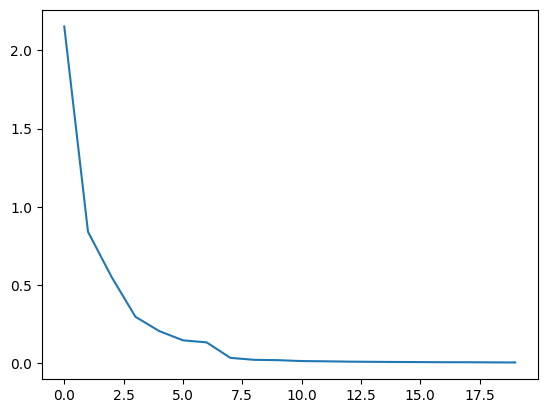

Accuracy of the network on the test images:  70.0 %


In [15]:
# TO DO:
# - instantiate the model and initialize it for reproducibility
# - train it, save the parameters, and plot the training loss
# - evaluate it and print the test accuracy

model_bn = CNNClassif_bnorm(input_size_linear, num_channels1, num_channels2, num_classes)
torch.manual_seed(0)
model_bn.apply(init_weights)

model_bn, train_losses_bn = training_cnn_classifier(model_bn, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=True)
torch.save(model_bn.state_dict(), 'model_cnn_classif_bn.pt')
plt.plot(train_losses_bn)
plt.show()

accuracy_bn = eval_cnn_classifier(model_bn, test_dataloader)
print('Accuracy of the network on the test images: ', accuracy_bn, '%')

<span style="color:red">**Q4**</span> In your report, provide the test accuracy of the network with batch norm. Also plot the training losses (both with and without batch norm on the same plot). What do you conclude?

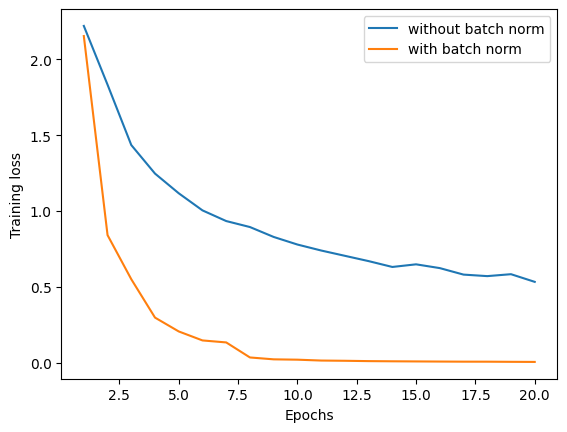

In [16]:
plt.figure()
plt.plot(np.arange(1, num_epochs+1), train_losses, label='without batch norm')
plt.plot(np.arange(1, num_epochs+1), train_losses_bn, label='with batch norm')
plt.xlabel('Epochs'), plt.ylabel('Training loss')
plt.legend()
plt.show()